In [6]:
%pip install albumentations


Note: you may need to restart the kernel to use updated packages.


In [9]:
import sys
!{sys.executable} -m pip install albumentations --user



In [1]:
import os 
import matplotlib.pyplot as plt 
import cv2 
import numpy as np
from PIL import Image
from multiprocessing import Pool, cpu_count
import albumentations as A
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from glob import glob
import glob
import shutil
import hashlib
import time

In [2]:
input_path = "dataset"
print(os.listdir(input_path))
path = os.path.join(input_path, "cad-cardiac-mri-dataset")

['Author Bios.docx', 'Normal', 'Sick']


In [7]:
path = "dataset"

In [8]:
def collect_images(main_path, category):
    """Recursively collects all image file paths from deeply nested subdirectories."""
    image_files = []  
    for root, _, files in os.walk(main_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append((os.path.abspath(os.path.join(root, file)), category))  # Store path + category
    return image_files

normal_images = collect_images(os.path.join(path, "Normal"), "Normal")
sick_images = collect_images(os.path.join(path, "Sick"), "Sick")

all_images = normal_images + sick_images

print(f"Unique normal images: {len(normal_images)}")
print(f"Unique sick images: {len(sick_images)}")
print(f"Total collected images: {len(all_images)}")


Unique normal images: 37564
Unique sick images: 21245
Total collected images: 58809


In [9]:
TARGET_SIZE = (512, 512) 
TO_GRAYSCALE = True  
APPLY_DENOISING = True  
APPLY_CONTRAST = True  
NORMALIZE_RANGE = (0, 1)  
BATCH_SIZE = 1000 
OUTPUT_DIR = "output"




In [10]:
os.makedirs(os.path.join(OUTPUT_DIR, "Normal"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "Sick"), exist_ok=True)

In [11]:
def preprocess_and_save(image_info):
    img_path, category = image_info 
    try:
        img = Image.open(img_path)
        if TO_GRAYSCALE:
            img = img.convert("L")
        else:
            img = img.convert("RGB")

        img = img.resize(TARGET_SIZE, Image.BICUBIC)
        img = np.array(img)

        if APPLY_DENOISING:
            img = cv2.medianBlur(img, 3)
            img = cv2.GaussianBlur(img, (3, 3), 0)

        if APPLY_CONTRAST:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            img = clahe.apply(img) if TO_GRAYSCALE else cv2.cvtColor(clahe.apply(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)), cv2.COLOR_GRAY2RGB)

        img = img.astype(np.float32) / 255.0
        if NORMALIZE_RANGE == (-1, 1):
            img = img * 2 - 1

        img = (img * 255).astype(np.uint8)

        # Ensure category folder exists
        save_folder = os.path.join(OUTPUT_DIR, category)
        os.makedirs(save_folder, exist_ok=True)

        # Generate a unique filename
        unique_id = hashlib.md5(img_path.encode()).hexdigest()[:8]
        timestamp = int(time.time() * 1000)  # Unique timestamp
        filename = f"{unique_id}_{timestamp}_{os.path.basename(img_path)}"
        save_path = os.path.join(save_folder, filename)

        # Save image
        cv2.imwrite(save_path, img)

    except Exception as e:
        print(f"Error processing {img_path}: {e}")

print("⚡ Preprocessing and saving images...")
for img_info in tqdm(all_images, total=len(all_images)):
    preprocess_and_save(img_info)

print(f"Preprocessing Complete! Images saved in: {OUTPUT_DIR}")

⚡ Preprocessing and saving images...


100%|██████████| 58809/58809 [13:29<00:00, 72.69it/s] 

Error processing c:\Mursaleen\4th semester\Machine Learning\Project\MRi(2)\dataset\Sick\Directory_27\SR_11\IM00039.jpg: cannot identify image file 'C:\\Mursaleen\\4th semester\\Machine Learning\\Project\\MRi(2)\\dataset\\Sick\\Directory_27\\SR_11\\IM00039.jpg'
Preprocessing Complete! Images saved in: output


In [16]:
normal_dir = os.path.join(OUTPUT_DIR, "Normal")
sick_dir = os.path.join(OUTPUT_DIR, "Sick")

num_normal = len(os.listdir(normal_dir)) if os.path.exists(normal_dir) else 0
num_sick = len(os.listdir(sick_dir)) if os.path.exists(sick_dir) else 0

print(f"Normal images: {num_normal}")
print(f"Sick images: {num_sick}")
print(f"Total images: {num_normal + num_sick}")

Normal images: 37564
Sick images: 21244
Total images: 58808


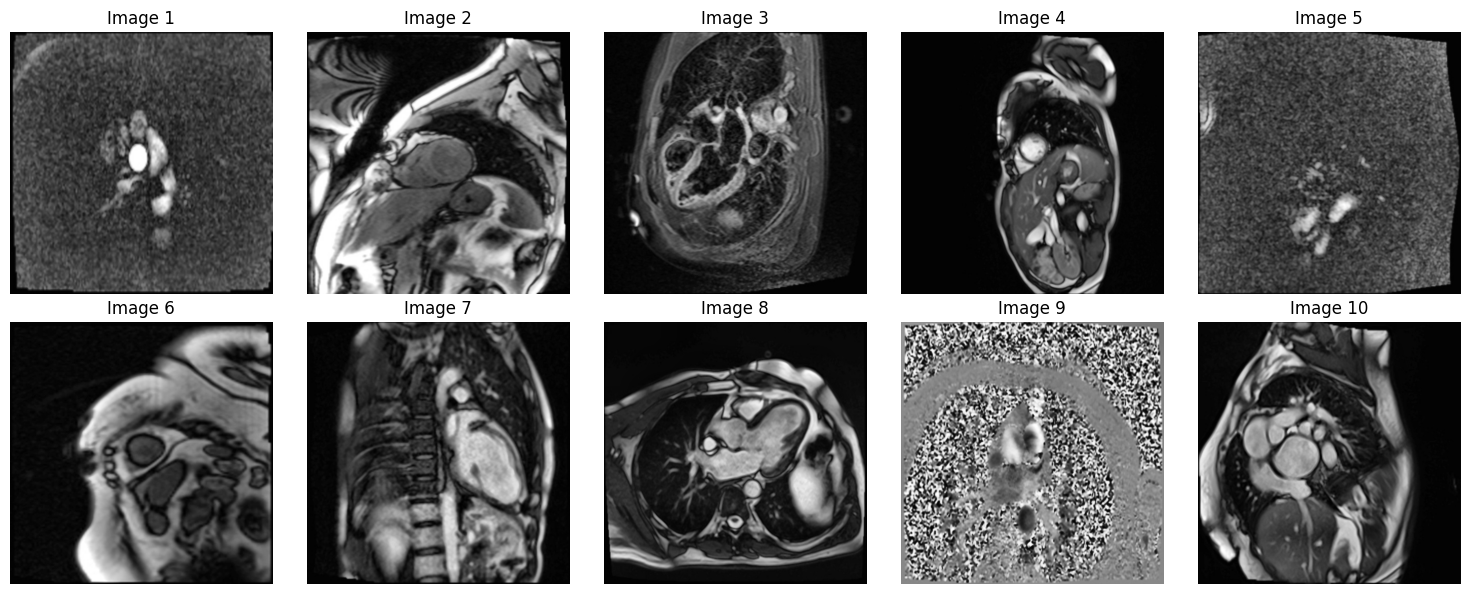

In [17]:
import random

normal_path = os.path.join(OUTPUT_DIR, "Normal")
sick_path = os.path.join(OUTPUT_DIR, "Sick")

num_images = 10  
cols = 5 
rows = (num_images + cols - 1) // cols  
normal_images = random.sample(os.listdir(normal_path), num_images // 2)
sick_images = random.sample(os.listdir(sick_path), num_images // 2)

image_files = [os.path.join(normal_path, img) for img in normal_images] + \
              [os.path.join(sick_path, img) for img in sick_images]

plt.figure(figsize=(15, rows * 3))

for i in range(len(image_files)):
    img = cv2.imread(image_files[i])

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image {i+1}")

plt.tight_layout()
plt.show()

In [29]:
sick_folder = r"C:\Mursaleen\4th semester\Machine Learning\Project\MRi(2)\output\Sick"

sick_images = glob.glob(os.path.join(sick_folder, "*.*"))
random.shuffle(sick_images)  

augmentations = A.Compose([
    A.HorizontalFlip(),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=1),
    A.GaussianBlur(p=0.3),
    A.RandomResizedCrop(height=512, width=512, scale=(0.8, 1.0), size=(512, 512), p=0.5)
])

def augment_and_save(image_path, save_dir):
    """Applies augmentation to an image and saves it."""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    augmented = augmentations(image=img)['image']
    augmented = cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR)
    filename = f"aug_{random.randint(10000, 99999)}_{os.path.basename(image_path)}"
    cv2.imwrite(os.path.join(save_dir, filename), augmented)

# Keep augmenting until Sick folder reaches 37,500 images
print("Augmenting Sick images...")
while len(glob.glob(os.path.join(sick_folder, "*.*"))) < 37500:
    batch = sick_images[:1000]  # Only process 1000 at a time to save RAM
    for img_path in tqdm(batch, total=len(batch)):
        if len(glob.glob(os.path.join(sick_folder, "*.*"))) >= 37500:
            break
        augment_and_save(img_path, sick_folder)

print(f"🎯 Augmentation completed! Total images in Sick: {len(glob.glob(os.path.join(sick_folder, '*.*')))}")

C:\Users\Fast Computer\AppData\Local\Temp\ipykernel_10620\2652854468.py:11: UserWarning: Argument(s) 'height, width' are not valid for transform RandomResizedCrop
  A.RandomResizedCrop(height=512, width=512, scale=(0.8, 1.0), size=(512, 512), p=0.5)


Augmenting Sick images...


 26%|██▌       | 259/1000 [02:24<06:54,  1.79it/s]


🎯 Augmentation completed! Total images in Sick: 37500


In [30]:
normal_dir = os.path.join(OUTPUT_DIR, "Normal")
sick_dir = os.path.join(OUTPUT_DIR, "Sick")

num_normal = len(os.listdir(normal_dir)) if os.path.exists(normal_dir) else 0
num_sick = len(os.listdir(sick_dir)) if os.path.exists(sick_dir) else 0

print(f"Normal images: {num_normal}")
print(f"Sick images: {num_sick}")
print(f"Total images: {num_normal + num_sick}")

Normal images: 37564
Sick images: 37500
Total images: 75064


In [31]:
output_path = "splitted"
for split in ["train", "valid", "test"]:
    for category in ["Normal", "Sick"]:
        os.makedirs(os.path.join(output_path, split, category), exist_ok=True)

In [32]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define input (original dataset) and output (splitted dataset) directories
SOURCE_DIR = "output"  # Change to your actual dataset path
OUTPUT_DIR = "splitted"  # Change to where you want to store the split dataset

# Ensure the output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Define subdirectories inside OUTPUT_DIR for train, val, and test
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(OUTPUT_DIR, split, "Normal"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, split, "Sick"), exist_ok=True)

# Function to split and copy images
def split_and_copy(class_name):
    class_dir = os.path.join(SOURCE_DIR, class_name)  # Path to original class folder
    images = os.listdir(class_dir)

    # Split dataset (70% Train, 15% Validation, 15% Test)
    train_files, test_val_files = train_test_split(images, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(test_val_files, test_size=0.5, random_state=42)

    # Define destination directories
    train_dest = os.path.join(OUTPUT_DIR, "train", class_name)
    val_dest = os.path.join(OUTPUT_DIR, "val", class_name)
    test_dest = os.path.join(OUTPUT_DIR, "test", class_name)

    # Copy files to respective directories
    for file in train_files:
        shutil.copy2(os.path.join(class_dir, file), os.path.join(train_dest, file))
    for file in val_files:
        shutil.copy2(os.path.join(class_dir, file), os.path.join(val_dest, file))
    for file in test_files:
        shutil.copy2(os.path.join(class_dir, file), os.path.join(test_dest, file))

    return len(train_files), len(val_files), len(test_files)

# Split and copy images for each class
train_n, val_n, test_n = split_and_copy("Normal")
train_s, val_s, test_s = split_and_copy("Sick")

# Print dataset distribution
print(f"Train: {train_n + train_s} images stored in {os.path.join(OUTPUT_DIR, 'train')}")
print(f"Validation: {val_n + val_s} images stored in {os.path.join(OUTPUT_DIR, 'val')}")
print(f"Test: {test_n + test_s} images stored in {os.path.join(OUTPUT_DIR, 'test')}")

OSError: [WinError 112] There is not enough space on the disk

In [1]:
import os
import random
import shutil
from tqdm import tqdm

# Set paths
original_normal_dir = r"C:\Mursaleen\4th semester\Machine Learning\Project\MRi(2)\output\Normal"
original_sick_dir = r"C:\Mursaleen\4th semester\Machine Learning\Project\MRi(2)\output\Sick"

output_base = r"C:\Mursaleen\4th semester\Machine Learning\Project\MRi(2)\output2"
output_normal_dir = os.path.join(output_base, "Normal")
output_sick_dir = os.path.join(output_base, "Sick")

# Create output directories if they don't exist
os.makedirs(output_normal_dir, exist_ok=True)
os.makedirs(output_sick_dir, exist_ok=True)

# Select and copy 10,000 Normal images
normal_images = os.listdir(original_normal_dir)
random.shuffle(normal_images)
for img_name in tqdm(normal_images[:10000], desc="Copying Normal"):
    src = os.path.join(original_normal_dir, img_name)
    dst = os.path.join(output_normal_dir, img_name)
    shutil.copy(src, dst)

# Select and copy 10,000 Sick images
sick_images = os.listdir(original_sick_dir)
random.shuffle(sick_images)
for img_name in tqdm(sick_images[:10000], desc="Copying Sick"):
    src = os.path.join(original_sick_dir, img_name)
    dst = os.path.join(output_sick_dir, img_name)
    shutil.copy(src, dst)

print("✅ Done! 10,000 images each copied to 'output_10000'.")


Copying Sick: 100%|██████████| 10000/10000 [00:22<00:00, 447.31it/s]

✅ Done! 10,000 images each copied to 'output_10000'.


In [2]:
output_path = r"C:\Mursaleen\4th semester\Machine Learning\Project\MRi(2)\splitted_dataset"

for split in ["train", "valid", "test"]:
    for category in ["Normal", "Sick"]:
        os.makedirs(os.path.join(output_path, split, category), exist_ok=True)

In [4]:
from sklearn.model_selection import train_test_split

SOURCE_DIR = r"C:\Mursaleen\4th semester\Machine Learning\Project\MRi(2)\output2"
OUTPUT_DIR = r"C:\Mursaleen\4th semester\Machine Learning\Project\MRi(2)\splitted_dataset"

# Create subdirectories
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(OUTPUT_DIR, split, "Normal"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, split, "Sick"), exist_ok=True)

# Function to split and copy images
def split_and_copy(class_name):
    class_dir = os.path.join(SOURCE_DIR, class_name)
    images = os.listdir(class_dir)

    # Split dataset: 70% train, 15% val, 15% test
    train_files, test_val_files = train_test_split(images, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(test_val_files, test_size=0.5, random_state=42)

    # Define destination folders
    train_dest = os.path.join(OUTPUT_DIR, "train", class_name)
    val_dest = os.path.join(OUTPUT_DIR, "val", class_name)
    test_dest = os.path.join(OUTPUT_DIR, "test", class_name)

    # Copy images
    for file in train_files:
        shutil.copy2(os.path.join(class_dir, file), os.path.join(train_dest, file))
    for file in val_files:
        shutil.copy2(os.path.join(class_dir, file), os.path.join(val_dest, file))
    for file in test_files:
        shutil.copy2(os.path.join(class_dir, file), os.path.join(test_dest, file))

    return len(train_files), len(val_files), len(test_files)

# Perform the split
train_n, val_n, test_n = split_and_copy("Normal")
train_s, val_s, test_s = split_and_copy("Sick")

# Print summary
print(f"Train: {train_n + train_s} images stored in {os.path.join(OUTPUT_DIR, 'train')}")
print(f"Validation: {val_n + val_s} images stored in {os.path.join(OUTPUT_DIR, 'val')}")
print(f"Test: {test_n + test_s} images stored in {os.path.join(OUTPUT_DIR, 'test')}")

Train: 14000 images stored in C:\Mursaleen\4th semester\Machine Learning\Project\MRi(2)\splitted_dataset\train
Validation: 3000 images stored in C:\Mursaleen\4th semester\Machine Learning\Project\MRi(2)\splitted_dataset\val
Test: 3000 images stored in C:\Mursaleen\4th semester\Machine Learning\Project\MRi(2)\splitted_dataset\test


In [5]:
splitted_dataset =  r"C:\Mursaleen\4th semester\Machine Learning\Project\MRi(2)\splitted_dataset"


def count_images(folder):
    return len([f for f in os.listdir(folder) if f.endswith(('.png', '.jpg', '.jpeg'))])

# Define paths
train_normal = os.path.join(splitted_dataset, "train", "Normal")
valid_normal = os.path.join(splitted_dataset, "val", "Normal")
test_normal = os.path.join(splitted_dataset, "test", "Normal")

train_sick = os.path.join(splitted_dataset, "train", "Sick")
valid_sick = os.path.join(splitted_dataset, "val", "Sick")
test_sick = os.path.join(splitted_dataset, "test", "Sick")

# Print counts
print("Training set - Normal:", count_images(train_normal))
print("Validation set - Normal:", count_images(valid_normal))
print("Test set - Normal:", count_images(test_normal))

print("Training set - Sick:", count_images(train_sick))
print("Validation set - Sick:", count_images(valid_sick))
print("Test set - Sick:", count_images(test_sick))

Training set - Normal: 7000
Validation set - Normal: 1500
Test set - Normal: 1500
Training set - Sick: 7000
Validation set - Sick: 1500
Test set - Sick: 1500


# Model Implementation

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import pickle

In [10]:
base_dir = r"C:\Mursaleen\4th semester\Machine Learning\Project\MRi(2)\splitted_dataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
model_save_path = os.path.join(base_dir, "cnn_model.pkl")
feature_save_path = os.path.join(base_dir, "mri_features.npy")
label_save_path = os.path.join(base_dir, "mri_labels.npy")

batch_size = 32
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = SimpleCNN().to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Training CNN...")
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")

Training CNN...
Epoch 1 Loss: 0.4359
Epoch 2 Loss: 0.1632
Epoch 3 Loss: 0.0831
Epoch 4 Loss: 0.0401
Epoch 5 Loss: 0.0228


In [14]:
with open(model_save_path, 'wb') as f:
    pickle.dump(model.state_dict(), f)
print(f"✅ Model saved to {model_save_path}")


✅ Model saved to C:\Mursaleen\4th semester\Machine Learning\Project\MRi(2)\splitted_dataset\cnn_model.pkl


In [15]:
model.eval()
features_list = []
labels_list = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        x = model.features(images)
        x = torch.flatten(x, 1)
        x = model.classifier[1](x)  # 128-d feature vector (ReLU layer)
        features_list.append(x.cpu().numpy())
        labels_list.append(labels.numpy())

features = np.vstack(features_list)
labels = np.hstack(labels_list)

np.save(feature_save_path, features)
np.save(label_save_path, labels)
print(f"✅ Features saved to {feature_save_path}")
print(f"✅ Labels saved to {label_save_path}")

✅ Features saved to C:\Mursaleen\4th semester\Machine Learning\Project\MRi(2)\splitted_dataset\mri_features.npy
✅ Labels saved to C:\Mursaleen\4th semester\Machine Learning\Project\MRi(2)\splitted_dataset\mri_labels.npy


# Evaluation

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the path to test data
test_dir = r"C:\Mursaleen\4th semester\Machine Learning\Project\MRi(2)\splitted_dataset\test"

# Use the same transforms as training
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [18]:
acc = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print(f"✅ Test Accuracy: {acc:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")

✅ Test Accuracy: 0.9570
✅ Precision: 0.9460
✅ Recall: 0.9693
✅ F1 Score: 0.9575


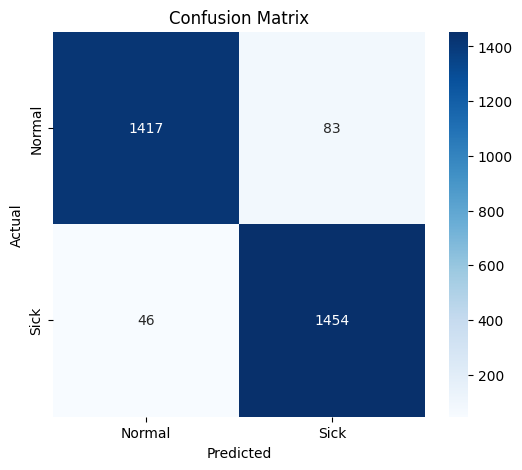

In [19]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Normal", "Sick"], yticklabels=["Normal", "Sick"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()